In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras import models , layers
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.layers import(
    GlobalAveragePooling2D,
    Dense,
    Dropout, 
    Input,
    Flatten
    )

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_curve
)

import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os


# --- 1. SETUP AND CONFIGURATION ---

In [3]:
# Check TF Version and set mixed precision
print(f"TensorFlow version: {tf.__version__}")
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled: mixed_float16")

TensorFlow version: 2.10.0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU, compute capability 8.6
Mixed precision enabled: mixed_float16


In [27]:
# Global parameters
train_dir = "Train"
test_dir = "Test"

IMG_SIZE = 256
BATCH_SIZE = 32
SEED = 42
CHANNELS = 3
EPOCHS =50

In [33]:
# --- 2. DATASET LOADING ---

# Create Training and Validation Datasets
# Note: We load images as [0-255] for now, the preprocessing function will handle the scaling later.
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = SEED,
    shuffle = True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 1748 files belonging to 7 classes.
Using 1486 files for training.
Found 1748 files belonging to 7 classes.
Using 262 files for validation.
Found 697 files belonging to 7 classes.


In [11]:
class_names = train_ds.class_names
print(f"\nClass names: {class_names}")


Class names: ['Bacterial Red disease', 'Bacterial diseases - Aeromoniasis', 'Bacterial gill disease', 'Fungal diseases Saprolegniasis', 'Healthy Fish', 'Parasitic diseases', 'Viral diseases White tail disease']


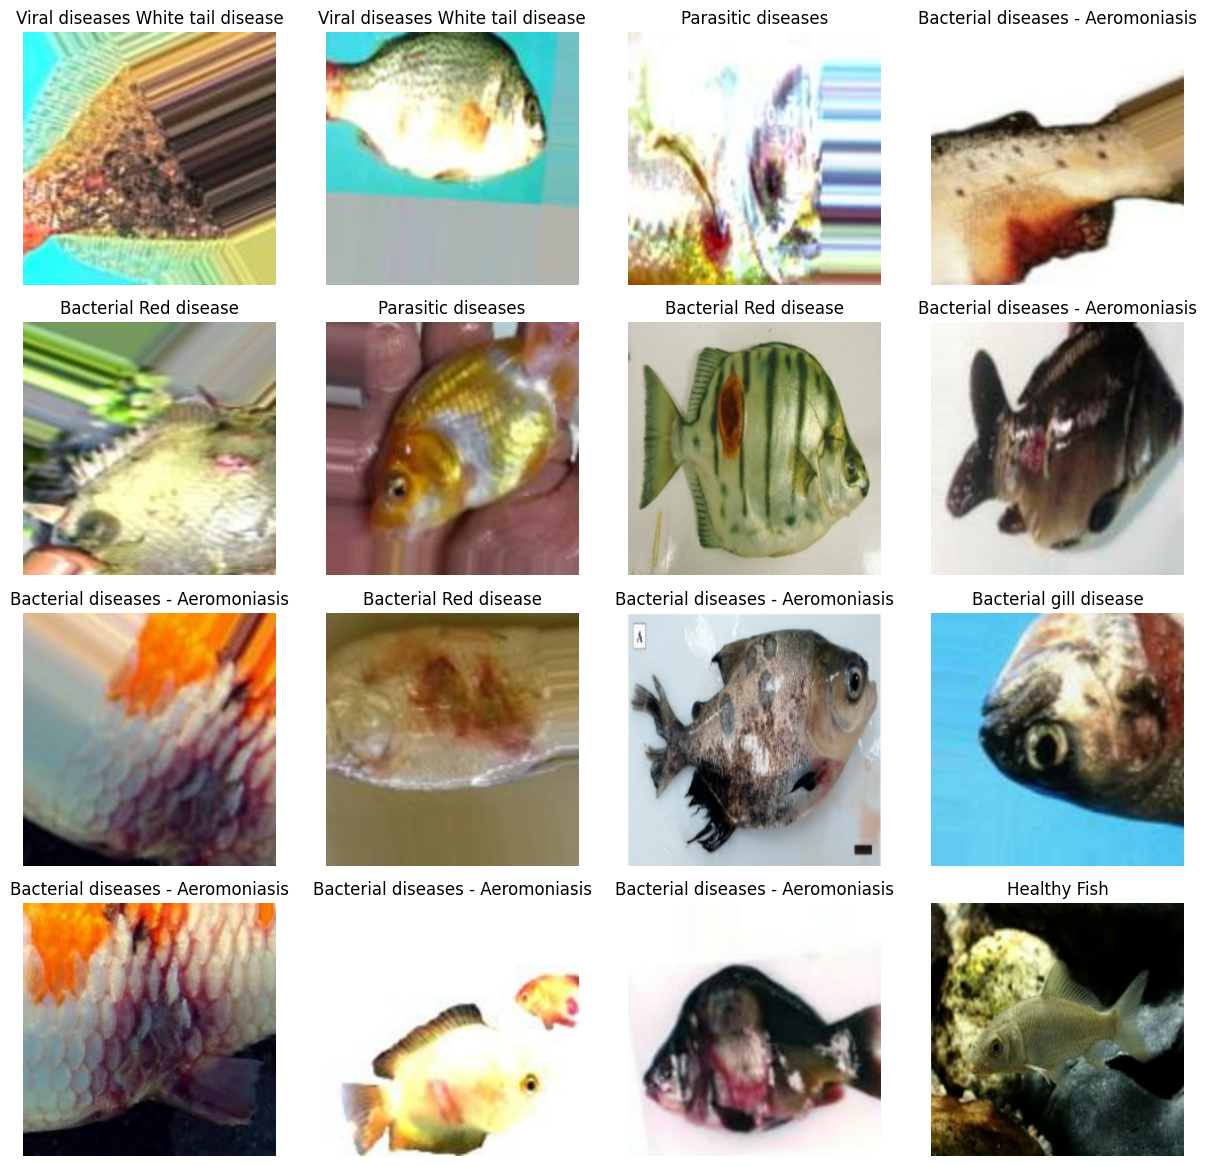

In [12]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE,IMG_SIZE),
  layers.Rescaling(1./255),
])

In [17]:
# --- 3. DATA AUGMENTATION AND PREPROCESSING ---

# 3A. Define the Data Augmentation layer
# Use tf.keras.layers to reference the preprocessing layers already available via the tf import
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1)
], name="Augmentation_Pipeline")

In [18]:
train_ds=train_ds.map(
    lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
# --- 4. MODEL BUILDING (RESNET50) ---
input_shape = (IMG_SIZE,IMG_SIZE,CHANNELS)
num_classes=len(class_names)

# 1️⃣ Load ResNet50 base (pre-trained on ImageNet)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,          
    input_shape=input_shape 
)

# 2️⃣ Initial state: Freeze feature extractor
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(384,activation = 'relu'),
    Dense(num_classes,activation='softmax')
])


In [25]:
# Compile model (Higher LR for new classification head)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]

In [28]:
print("\n--- Starting Phase 1: Training New Head (Frozen ResNet50) ---")
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE, 
    validation_data=val_ds,
    verbose = 1,
    epochs=EPOCHS,
    callbacks=callback
)


--- Starting Phase 1: Training New Head (Frozen ResNet50) ---
Epoch 1/50
47/47 [==============================] - 27s 260ms/step - loss: 21.2386 - accuracy: 0.3890 - val_loss: 1.6808 - val_accuracy: 0.5611
Epoch 2/50
47/47 [==============================] - 10s 222ms/step - loss: 0.5197 - accuracy: 0.8176 - val_loss: 0.9875 - val_accuracy: 0.7214
Epoch 3/50
47/47 [==============================] - 10s 219ms/step - loss: 0.1767 - accuracy: 0.9448 - val_loss: 0.9910 - val_accuracy: 0.7366
Epoch 4/50
47/47 [==============================] - 10s 218ms/step - loss: 0.0424 - accuracy: 0.9919 - val_loss: 0.9761 - val_accuracy: 0.7519
Epoch 5/50
47/47 [==============================] - 10s 216ms/step - loss: 0.0214 - accuracy: 0.9960 - val_loss: 0.9738 - val_accuracy: 0.7634
Epoch 6/50
47/47 [==============================] - 10s 218ms/step - loss: 0.0131 - accuracy: 0.9973 - val_loss: 0.9531 - val_accuracy: 0.7672
Epoch 7/50
47/47 [==============================] - 10s 216ms/step - loss: 0.0

In [34]:
all_predictions = []
all_labels = []
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

1/1 [==============================] - 2s 2s/step


In [35]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9770444763271162
F1 Score:  0.9770896951740574
Recall:  0.9770444763271162
Precision:  0.9773818849047426


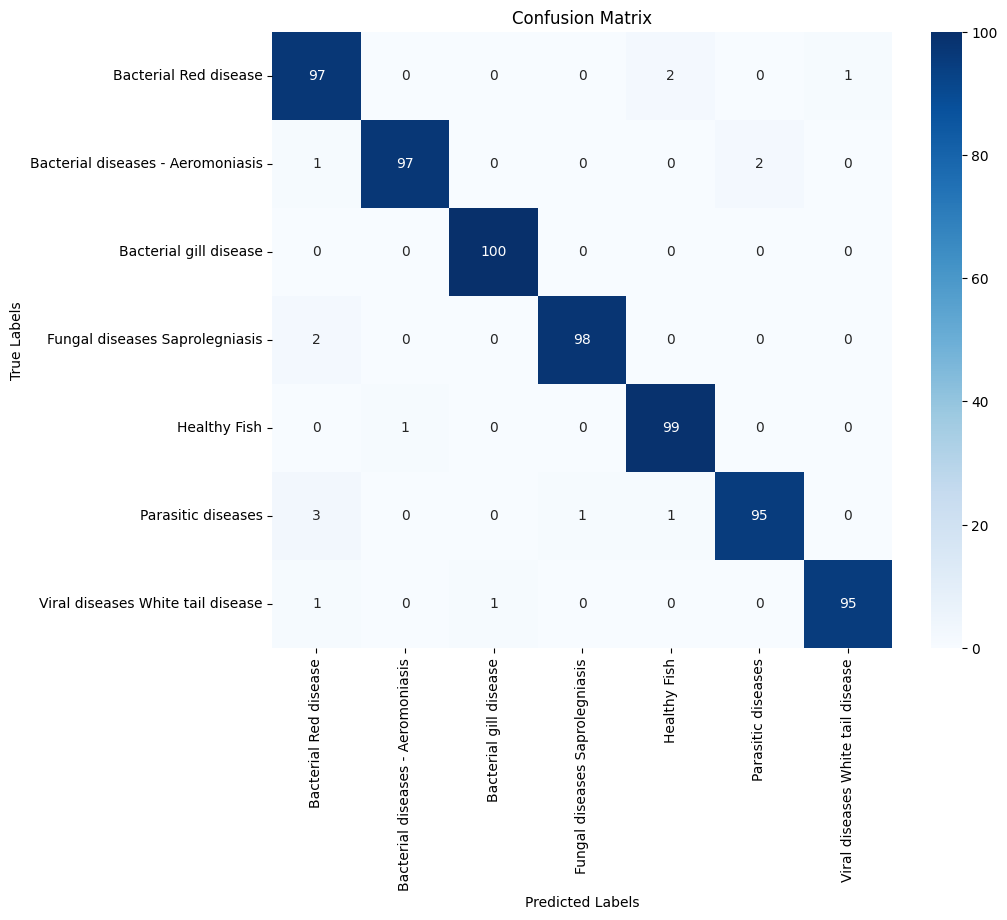

In [36]:

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()


In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


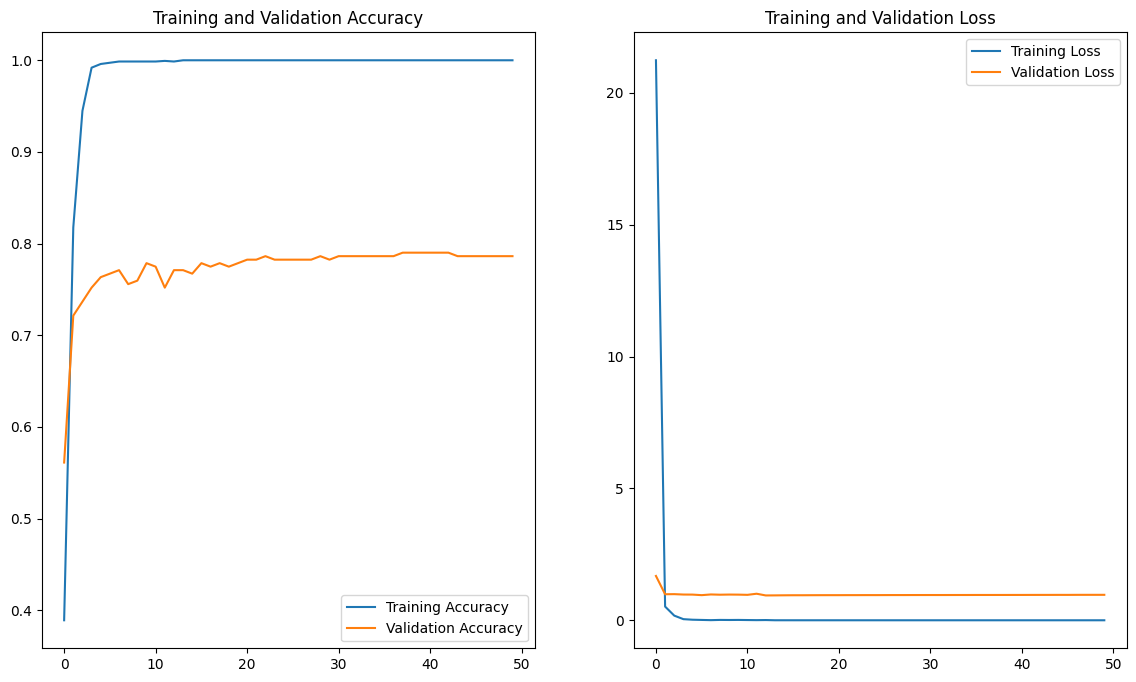

In [38]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('curves.png', dpi = 300)
plt.show()

In [42]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    img = Image.open(image_path)
    plt.imshow(img)
    print("Predicted class:", predicted_class) 

1/1 [==============================] - 1s 537ms/step
Predicted class: Bacterial diseases - Aeromoniasis


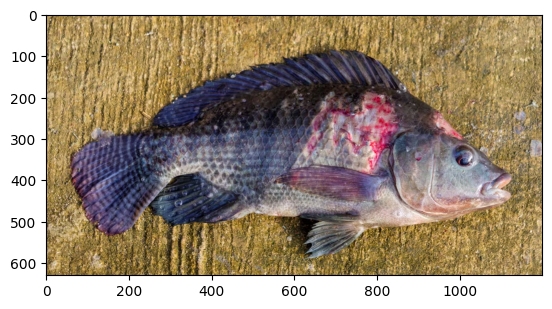

In [43]:
sample_predict(model, "C:/Users/shafe/Downloads/Tilapia-infected-with-Aeromonas (1).avif")